# Train a FF network

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""Main script used for training."""
from tensorflow.keras.callbacks import TensorBoard, CSVLogger
from tensorflow.keras.models import load_model
import keras.metrics
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from nmp import model as mod
from nmp import dataset, ev_metrics
from nmp.dataset import pyplot_piano_roll
from nmp import plotter
from pathlib import Path
import time
import math
import pypianoroll
from pypianoroll import Multitrack, Track
import numpy as np
import random
import copy
import tensorflow as tf

NOTES = '-' + 'no-down'
# NOTES = '-' + 'ff'

# P = Path(__file__).parent.absolute()
P = Path(os.path.abspath(''))  # Compatible with Jupyter Notebook
P2 = P / "datasets"  # Dataset path

PLOTS = P / 'plots'  # Plots path
FS = 24  # Sampling frequency. 10 Hz = 100 ms
Q = 0  # Quantize?
st = 10  # Past timesteps
num_ts = 10  # Predicted timesteps
DOWN = 1  # Downsampling factor

D = "data/POP909" # Dataset
#D = "data/Piano-midi.de"  # Dataset
# D = "data/Nottingham"  # Dataset
# D = "data/JSB Chorales"  # Dataset

# 64 notes
# LOW_LIM = 33  # A1
# HIGH_LIM = 97  # C7

# LOW_LIM = 36  # C2
# HIGH_LIM = 85  # C6

# Complete 88-key keyboard
LOW_LIM = 21  # A0
HIGH_LIM = 109  # C8

NUM_NOTES = HIGH_LIM - LOW_LIM
CROP = [LOW_LIM, HIGH_LIM]  # Crop plots

LOAD = 0
TRANS = 0

Using TensorFlow backend.


### Generate list of MIDI files

In [2]:
# train_list = [x for x in os.listdir(P / D / 'train') if x.endswith('.mid')]
# validation_list = [x for x in os.listdir(P / D / 'valid') if x.endswith('.mid')]
# test_list = [x for x in os.listdir(P / D / 'test') if x.endswith('.mid')]

# print("\nTrain list:  ", train_list)
# print("\nValidation list:  ", validation_list)
# print("\nTest list:  ", test_list)

In [3]:
train_list = ['752.mid',  '007.mid',  '577.mid',  '840.mid',  '747.mid',  '851.mid',  '805.mid',  '227.mid',  '724.mid',  '786.mid',  '760.mid',  '297.mid',  '042.mid',  '260.mid',  '031.mid',  '819.mid',  '616.mid',  '476.mid',  '829.mid',  '119.mid',  '572.mid',  '642.mid',  '050.mid',  '825.mid',  '140.mid',  '734.mid',  '283.mid',  '494.mid',  '249.mid',  '041.mid',  '264.mid',  '280.mid',  '612.mid',  '908.mid',  '180.mid',  '281.mid',  '697.mid',  '221.mid',  '021.mid',  '465.mid',  '618.mid',  '702.mid',  '509.mid',  '458.mid',  '058.mid',  '463.mid',  '769.mid',  '810.mid',  '094.mid',  '552.mid',  '729.mid',  '108.mid',  '312.mid',  '011.mid',  '626.mid',  '220.mid',  '844.mid',  '793.mid',  '096.mid',  '460.mid',  '613.mid',  '508.mid',  '762.mid',  '667.mid',  '437.mid',  '606.mid',  '254.mid',  '081.mid',  '641.mid',  '075.mid',  '610.mid',  '211.mid',  '016.mid',  '705.mid',  '348.mid',  '901.mid',  '766.mid',  '863.mid',  '847.mid',  '631.mid',  '664.mid',  '532.mid',  '020.mid',  '292.mid',  '623.mid',  '087.mid',  '902.mid',  '779.mid',  '562.mid',  '879.mid',  '733.mid',  '516.mid',  '644.mid',  '470.mid',  '206.mid',  '381.mid',  '796.mid',  '486.mid',  '032.mid',  '628.mid',  '074.mid',  '759.mid',  '482.mid',  '053.mid',  '104.mid',  '082.mid',  '787.mid',  '313.mid',  '780.mid',  '666.mid',  '033.mid',  '274.mid',  '539.mid',  '059.mid',  '814.mid',  '771.mid',  '848.mid',  '596.mid',  '440.mid',  '103.mid',  '827.mid',  '318.mid',  '099.mid',  '377.mid',  '806.mid',  '417.mid',  '432.mid',  '341.mid',  '427.mid',  '487.mid',  '362.mid',  '764.mid',  '361.mid',  '679.mid',  '900.mid',  '236.mid',  '521.mid',  '030.mid',  '590.mid',  '708.mid',  '797.mid',  '423.mid',  '238.mid',  '259.mid',  '101.mid',  '866.mid',  '382.mid',  '354.mid',  '201.mid',  '579.mid',  '163.mid',  '454.mid',  '289.mid',  '047.mid',  '380.mid',  '089.mid',  '881.mid',  '268.mid',  '886.mid',  '137.mid',  '029.mid',  '152.mid',  '831.mid',  '565.mid',  '714.mid',  '241.mid',  '808.mid',  '149.mid',  '651.mid',  '512.mid',  '830.mid',  '102.mid',  '868.mid',  '327.mid',  '188.mid',  '858.mid',  '538.mid',  '334.mid',  '854.mid',  '561.mid',  '177.mid',  '267.mid',  '776.mid',  '340.mid',  '234.mid',  '159.mid',  '005.mid',  '045.mid',  '006.mid',  '366.mid',  '686.mid',  '242.mid',  '004.mid',  '455.mid',  '148.mid',  '375.mid',  '755.mid',  '068.mid',  '653.mid',  '205.mid',  '654.mid',  '749.mid',  '135.mid',  '601.mid',  '585.mid',  '126.mid',  '818.mid',  '196.mid',  '892.mid',  '491.mid',  '038.mid',  '865.mid',  '420.mid',  '085.mid',  '632.mid',  '243.mid',  '728.mid',  '385.mid',  '598.mid',  '647.mid',  '147.mid',  '436.mid',  '043.mid',  '233.mid',  '052.mid',  '899.mid',  '302.mid',  '730.mid',  '328.mid',  '300.mid',  '014.mid',  '514.mid',  '225.mid',  '849.mid',  '556.mid',  '669.mid',  '557.mid',  '378.mid',  '580.mid',  '757.mid',  '421.mid',  '741.mid',  '547.mid',  '396.mid',  '250.mid',  '816.mid',  '459.mid',  '661.mid',  '905.mid',  '311.mid',  '609.mid',  '520.mid',  '346.mid',  '597.mid',  '739.mid',  '523.mid',  '857.mid',  '284.mid',  '124.mid',  '198.mid',  '870.mid',  '208.mid',  '659.mid',  '542.mid',  '737.mid',  '820.mid',  '856.mid',  '061.mid',  '412.mid',  '513.mid',  '171.mid',  '874.mid',  '717.mid',  '600.mid',  '673.mid',  '176.mid',  '475.mid',  '398.mid',  '794.mid',  '111.mid',  '235.mid',  '802.mid',  '301.mid',  '790.mid',  '799.mid',  '589.mid',  '652.mid',  '430.mid',  '293.mid',  '431.mid',  '871.mid',  '428.mid',  '189.mid',  '010.mid',  '690.mid',  '139.mid',  '614.mid',  '492.mid',  '490.mid',  '093.mid',  '091.mid',  '853.mid',  '804.mid',  '833.mid',  '484.mid',  '474.mid',  '161.mid',  '228.mid',  '852.mid',  '355.mid',  '510.mid',  '477.mid',  '210.mid',  '299.mid',  '891.mid',  '680.mid',  '121.mid',  '237.mid',  '174.mid',  '782.mid',  '204.mid',  '706.mid',  '674.mid',  '401.mid',  '257.mid',  '884.mid',  '563.mid',  '118.mid',  '869.mid',  '534.mid',  '187.mid',  '409.mid',  '347.mid',  '712.mid',  '587.mid',  '685.mid',  '411.mid',  '663.mid',  '823.mid',  '675.mid',  '441.mid',  '843.mid',  '232.mid',  '599.mid',  '216.mid',  '517.mid',  '622.mid',  '707.mid',  '157.mid',  '290.mid',  '394.mid',  '164.mid',  '374.mid',  '453.mid',  '229.mid',  '190.mid',  '504.mid',  '506.mid',  '719.mid',  '343.mid',  '051.mid',  '480.mid',  '298.mid',  '461.mid',  '607.mid',  '287.mid',  '586.mid',  '325.mid',  '403.mid',  '009.mid',  '286.mid',  '046.mid',  '349.mid',  '128.mid',  '212.mid',  '263.mid',  '314.mid',  '360.mid',  '429.mid',  '273.mid',  '275.mid',  '084.mid',  '181.mid',  '129.mid',  '689.mid',  '071.mid',  '529.mid',  '387.mid',  '692.mid',  '839.mid',  '064.mid',  '272.mid',  '560.mid',  '008.mid',  '282.mid',  '414.mid',  '337.mid',  '735.mid',  '244.mid',  '745.mid',  '266.mid',  '391.mid',  '554.mid',  '615.mid',  '027.mid',  '117.mid',  '389.mid',  '390.mid',  '063.mid',  '305.mid',  '317.mid',  '803.mid',  '369.mid',  '449.mid',  '452.mid',  '896.mid',  '813.mid',  '395.mid',  '778.mid',  '097.mid',  '370.mid',  '023.mid',  '758.mid',  '306.mid',  '105.mid',  '136.mid',  '223.mid',  '545.mid',  '608.mid',  '496.mid',  '248.mid',  '546.mid',  '677.mid',  '141.mid',  '862.mid',  '525.mid',  '462.mid',  '864.mid',  '495.mid',  '483.mid',  '602.mid',  '442.mid',  '701.mid',  '637.mid',  '883.mid',  '640.mid',  '367.mid',  '049.mid',  '571.mid',  '433.mid',  '182.mid',  '594.mid',  '630.mid',  '682.mid',  '535.mid',  '875.mid',  '678.mid',  '836.mid',  '817.mid',  '656.mid',  '419.mid',  '573.mid',  '595.mid',  '657.mid',  '383.mid',  '636.mid',  '070.mid',  '247.mid',  '822.mid',  '392.mid',  '522.mid',  '450.mid',  '750.mid',  '158.mid',  '672.mid',  '537.mid',  '333.mid',  '399.mid',  '772.mid',  '256.mid',  '133.mid',  '376.mid',  '906.mid',  '768.mid',  '246.mid',  '186.mid',  '751.mid',  '795.mid',  '239.mid',  '443.mid',  '604.mid',  '773.mid',  '332.mid',  '882.mid',  '162.mid',  '511.mid',  '605.mid',  '357.mid',  '658.mid',  '801.mid',  '167.mid',  '564.mid',  '447.mid',  '386.mid',  '800.mid',  '226.mid',  '252.mid',  '240.mid',  '165.mid',  '481.mid',  '320.mid',  '807.mid',  '365.mid',  '079.mid',  '015.mid',  '634.mid',  '688.mid',  '611.mid',  '889.mid',  '086.mid',  '285.mid',  '582.mid',  '592.mid',  '501.mid',  '090.mid',  '559.mid',  '372.mid',  '321.mid',  '894.mid',  '034.mid',  '909.mid',  '665.mid',  '620.mid',  '388.mid',  '307.mid',  '815.mid',  '826.mid',  '467.mid',  '754.mid',  '726.mid',  '213.mid',  '316.mid',  '065.mid',  '145.mid',  '890.mid',  '358.mid',  '699.mid',  '872.mid',  '770.mid',  '888.mid',  '156.mid',  '732.mid',  '342.mid',  '352.mid',  '485.mid',  '415.mid',  '784.mid',  '811.mid',  '037.mid',  '278.mid',  '531.mid',  '788.mid',  '224.mid',  '426.mid',  '765.mid',  '054.mid',  '329.mid',  '183.mid',  '350.mid',  '783.mid',  '738.mid',  '583.mid',  '368.mid',  '245.mid',  '132.mid',  '791.mid',  '635.mid',  '528.mid',  '774.mid',  '416.mid',  '649.mid'] 
validation_list = ['553.mid',  '691.mid',  '003.mid',  '258.mid',  '767.mid',  '336.mid',  '066.mid',  '478.mid',  '723.mid',  '356.mid',  '112.mid',  '731.mid',  '203.mid',  '170.mid',  '885.mid',  '115.mid',  '627.mid',  '364.mid',  '098.mid',  '444.mid',  '277.mid',  '261.mid',  '880.mid',  '681.mid',  '469.mid',  '013.mid',  '265.mid',  '393.mid',  '057.mid',  '541.mid',  '789.mid',  '763.mid',  '144.mid',  '055.mid',  '330.mid',  '155.mid',  '574.mid',  '202.mid',  '276.mid',  '527.mid',  '143.mid',  '526.mid',  '077.mid',  '576.mid',  '291.mid',  '026.mid',  '670.mid',  '296.mid',  '036.mid',  '116.mid',  '012.mid',  '683.mid',  '898.mid',  '821.mid',  '570.mid',  '558.mid',  '568.mid',  '581.mid',  '345.mid',  '218.mid',  '655.mid',  '524.mid',  '471.mid',  '530.mid',  '488.mid',  '172.mid',  '134.mid',  '434.mid',  '543.mid',  '173.mid',  '222.mid',  '575.mid',  '251.mid',  '168.mid',  '138.mid',  '715.mid',  '353.mid',  '878.mid',  '698.mid',  '695.mid',  '505.mid',  '062.mid',  '753.mid',  '877.mid',  '083.mid',  '438.mid',  '195.mid',  '076.mid',  '197.mid',  '185.mid',  '445.mid',  '876.mid',  '859.mid',  '219.mid',  '373.mid',  '824.mid',  '696.mid',  '838.mid',  '718.mid',  '279.mid',  '424.mid',  '710.mid',  '178.mid',  '549.mid',  '035.mid',  '603.mid',  '761.mid',  '130.mid',  '855.mid',  '209.mid',  '448.mid',  '078.mid',  '887.mid',  '536.mid',  '662.mid',  '617.mid',  '022.mid',  '326.mid',  '593.mid',  '199.mid',  '497.mid',  '092.mid',  '384.mid',  '756.mid',  '351.mid',  '072.mid',  '468.mid',  '700.mid',  '473.mid',  '308.mid',  '404.mid',  '841.mid',  '668.mid',  '400.mid',  '544.mid',  '060.mid',  '439.mid',  '850.mid',  '120.mid',  '725.mid',  '503.mid',  '095.mid',  '088.mid',  '153.mid',  '671.mid',  '646.mid']
test_list = ['100.mid',  '044.mid',  '080.mid',  '335.mid',  '621.mid',  '716.mid',  '639.mid',  '555.mid',  '125.mid',  '169.mid',  '175.mid',  '304.mid',  '837.mid',  '584.mid',  '456.mid',  '214.mid',  '406.mid',  '123.mid',  '873.mid',  '410.mid',  '106.mid',  '861.mid',  '798.mid',  '017.mid',  '502.mid',  '191.mid',  '893.mid',  '110.mid',  '402.mid',  '425.mid',  '533.mid',  '215.mid',  '200.mid',  '407.mid',  '897.mid',  '643.mid',  '363.mid',  '253.mid',  '907.mid',  '024.mid',  '709.mid',  '303.mid',  '775.mid',  '315.mid',  '413.mid',  '721.mid',  '720.mid',  '109.mid',  '832.mid',  '713.mid',  '742.mid',  '548.mid',  '748.mid',  '217.mid',  '154.mid',  '069.mid',  '704.mid',  '472.mid',  '113.mid',  '151.mid',  '127.mid',  '740.mid',  '184.mid',  '270.mid',  '860.mid',  '479.mid',  '498.mid',  '194.mid',  '269.mid',  '324.mid',  '777.mid',  '518.mid',  '629.mid',  '344.mid',  '624.mid',  '591.mid',  '371.mid',  '146.mid',  '566.mid',  '809.mid',  '711.mid',  '295.mid',  '903.mid',  '339.mid',  '039.mid',  '567.mid',  '569.mid',  '633.mid',  '405.mid',  '142.mid',  '048.mid',  '744.mid',  '507.mid',  '867.mid',  '230.mid',  '107.mid',  '660.mid',  '812.mid',  '160.mid',  '056.mid',  '551.mid',  '684.mid',  '192.mid',  '540.mid',  '114.mid',  '073.mid',  '207.mid',  '435.mid',  '828.mid',  '150.mid',  '379.mid',  '693.mid',  '835.mid',  '288.mid',  '271.mid',  '001.mid',  '331.mid',  '746.mid',  '842.mid',  '645.mid',  '451.mid',  '457.mid',  '422.mid',  '619.mid',  '650.mid',  '122.mid',  '408.mid',  '466.mid',  '255.mid',  '231.mid',  '309.mid',  '519.mid',  '500.mid',  '736.mid',  '323.mid',  '067.mid',  '019.mid',  '040.mid',  '338.mid',  '294.mid',  '464.mid',  '588.mid',  '397.mid',  '578.mid',  '489.mid',  '904.mid',  '131.mid',  '179.mid',  '834.mid',  '319.mid',  '687.mid',  '792.mid',  '322.mid',  '025.mid',  '193.mid',  '845.mid',  '727.mid',  '703.mid',  '359.mid',  '002.mid',  '625.mid',  '262.mid',  '781.mid',  '515.mid',  '638.mid',  '418.mid',  '493.mid',  '895.mid',  '648.mid',  '499.mid',  '028.mid',  '785.mid',  '446.mid',  '676.mid',  '018.mid',  '550.mid',  '694.mid',  '743.mid',  '846.mid',  '310.mid',  '166.mid',  '722.mid']

In [4]:
# re
train_list = train_list[0:72]
validation_list = validation_list[0:18]
test_list = test_list[0:23]

In [5]:
print("\nTrain list:  ", len(train_list))
print("\nValidation list:  ", len(validation_list))
print("\nTest list:  ", len(test_list))


Train list:   72

Validation list:   18

Test list:   23


## Datasets

### Generate data from lists
Training, validation and test sets.

In [6]:
start = time.time()

train = dataset.Dataset(train_list, P / D / 'train',  fs=FS, bl=0, quant=Q)
validation = dataset.Dataset(validation_list, P / D / 'valid',  fs=FS, bl=0, quant=Q)
test = dataset.Dataset(test_list, P / D / 'test',  fs=FS, bl=0, quant=Q)

train.build_dataset("training", step=st, t_step=num_ts, steps=st,
                    down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)
validation.build_dataset("validation", step=st, t_step=num_ts, steps=st,
                         down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)
test.build_dataset("test", step=st, t_step=num_ts, steps=st,
                   down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)

end = time.time()
print("Done")
print("Loading time: %.2f" % (end-start))

Building training dataset (72 files)
Building validation dataset (18 files)
Building test dataset (23 files)
Done
Loading time: 149.02


In [7]:
print(train.dataset[0].shape)
print(train.dataset[1].shape)

(578232, 10, 88)
(578232, 880)


### Save dataset

In [20]:
np.save(P2 / '64-18-step' / 'train.input', train.dataset[0], allow_pickle=True)
np.save(P2 / '64-18-step' / 'train.target', train.dataset[1], allow_pickle=True)
np.save(P2 / '64-18-step' / 'valid.input', validation.dataset[0], allow_pickle=True)
np.save(P2 / '64-18-step' / 'valid.target', validation.dataset[1], allow_pickle=True)
np.save(P2 / '64-18-step' / 'test.input', test.dataset[0], allow_pickle=True)
np.save(P2 / '64-18-step' / 'test.target', test.dataset[1], allow_pickle=True)

### Piano rolls of training dataset
Input and output piano rolls

(21.0, 109.0)

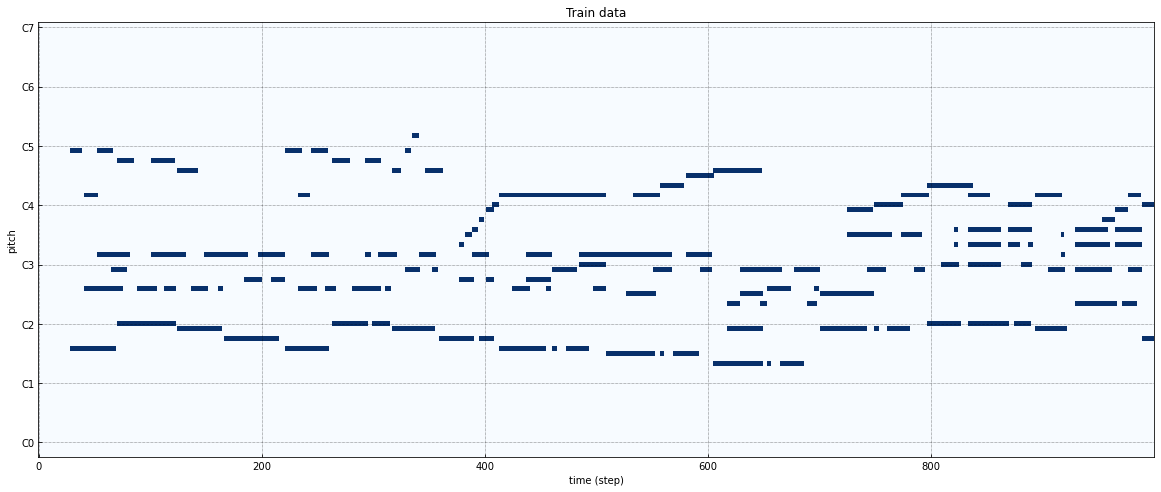

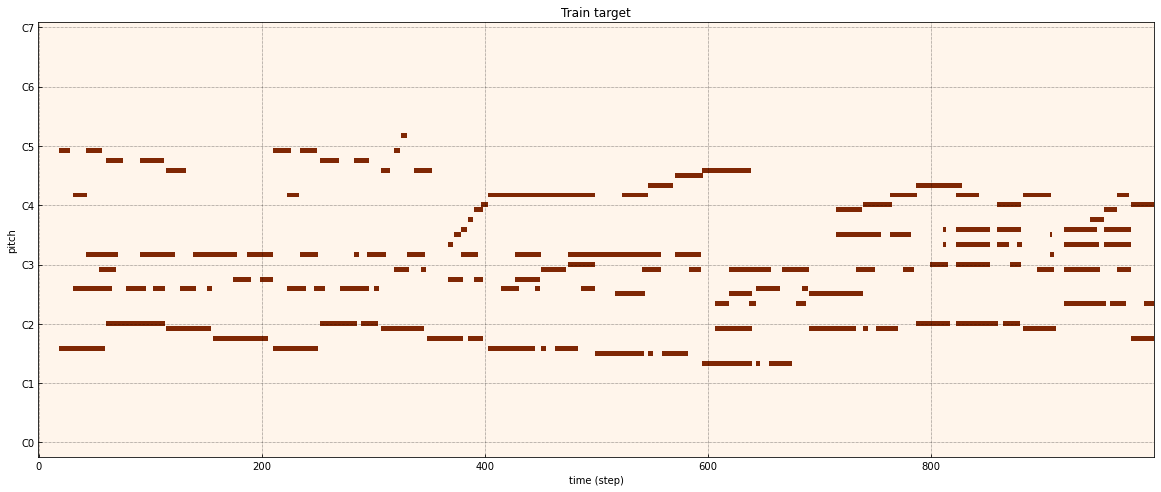

In [8]:
plt.rcParams["figure.figsize"] = (20, 8)
# pyplot_piano_roll(train.dataset[0][:, 0, :],
#                   low_lim=LOW_LIM, high_lim=HIGH_LIM)
pyplot_piano_roll(train.dataset[0][:1000, 0, :],
                  low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Train data")
plt.ylim(CROP)
pyplot_piano_roll(train.dataset[1][:1000, :NUM_NOTES], cmap="Oranges",
                  low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Train target")
plt.ylim(CROP)

## Keras
### Build the model

In [9]:
LOAD = 0
model_path = str(P / 'models' / 'model-down-trans-64-4-20epochs')
BS = 64  # Batch size
import importlib
importlib.reload(mod)
importlib.reload(dataset)
import time

In [10]:
# L = train.dataset[0].shape[0]
# L -= L % BS
# x = train.dataset[0][:L, :, :]
# y = train.dataset[1][:L, :]
# train.dataset = (x, y)

# L = validation.dataset[0].shape[0]
# L -= L % BS
# x = validation.dataset[0][:L, :, :]
# y = validation.dataset[1][:L, :]
# validation.dataset = (x, y)

# train.dataset[0].shape

In [11]:
if LOAD:
    model = load_model(filepath=model_path,
                       custom_objects=None,
                       compile=True)

else:
    model = mod.build_model((st, NUM_NOTES), (num_ts), NUM_NOTES, BS)
    mod.compile_model(model, 'binary_crossentropy', 'adam',
                      metrics=['accuracy', mod.f1, keras.metrics.Precision(), keras.metrics.Recall()])

model.summary()

now = datetime.now()

# Save logs
logger = TensorBoard(log_dir=P / 'logs' / now.strftime("%Y%m%d-%H%M%S"),
                     write_graph=True, update_freq='epoch')

csv_logger = CSVLogger(P / 'logs' / (now.strftime("%Y%m%d-%H%M%S") + '-' +
                       str(st) + '-' + str(num_ts) + '.csv'),
                       separator=',', append=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10, 32)            2848      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                10272     
_________________________________________________________________
Output (Dense)               (None, 880)               29040     
Total params: 42,160
Trainable params: 42,160
Non-trainable params: 0
_________________________________________________________________


### Checkpoints

In [12]:
# Directory where the checkpoints will be saved
checkpoint_dir = P / ('models/training_checkpoints/' + now.strftime("%Y%m%d-%H%M%S"))
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_best_only=True,
    period=1)

### Fit the model
Define batch size ```BS``` and number of ```epochs```

#### Fit with reset_state

In [13]:
# # Fit generator the model.
# random.seed(40)
# epochs = 1
# start = time.time()
# train_loss = []
# train_acc = []
# val_loss = []

# size_valid = math.floor(validation.dataset[0].shape[0] / BS)
# spe_valid = size_valid

# cnt = 0
# choice = list(range(len(train.data)))
# for _ in range(20):  # Epochs
#     random.shuffle(choice)
#     print("List: ", choice)
#     song = 0
#     train_song_loss = []
#     train_song_acc = []
#     val_song_loss = []
#     last_song = 0
    
#     for i in choice:
# #         print("song", i)
#         x = copy.deepcopy(train.data[i])
#         y = copy.deepcopy(train.targets[i])
#         song += 1
#         if song == len(train.data):
#             last_song = 1
        
#         size_train = math.floor(len(x) / BS)
#         spe_train = math.floor(size_train / 10)

#         if not last_song:
#             history = model.fit(dataset.generate_stateful((x[:size_train*BS, :, :],
#                                                            y[:size_train*BS, :]), bs=BS, trans=1), epochs=epochs,
#                                 steps_per_epoch=spe_train, verbose=0)    
# #             print("s", song)
                   
#         else:
#             history = model.fit(dataset.generate_stateful((x, y), bs=BS, trans=1), epochs=epochs,
#                       steps_per_epoch=spe_train,
#                       validation_data=dataset.generate((validation.dataset[0][:size_valid*BS, :, :],
#                                                         validation.dataset[1][:size_valid*BS, :]), bs=BS),
#                       validation_steps=spe_valid, verbose=1)
#             print("Epoch %d finished" % cnt)
#             cnt += 1

#             train_song_loss.append(history.history['loss'])
#             train_song_acc.append(history.history['accuracy'])
#             val_song_loss.append(history.history['val_loss'])


        
#         model.reset_states()
    
#     train_loss.append(np.mean(train_song_loss))
#     train_acc.append(np.mean(train_song_acc))
#     val_loss.append(np.mean(val_song_loss))
    
#     end = time.time()

In [14]:
# fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 4))
# plt.plot(val_loss, 'o-', c='tab:orange', label='Validation', ms=8, alpha=0.8)
# plt.plot(train_loss, 'o-', c='tab:red', label='Train', ms=8, alpha=0.8)
# plt.xlabel('Epoch')
# plt.xticks(range(epochs))
# plt.legend()
# plt.title('Loss: Binary cross-entropy')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# plt.ylim([0.000, 0.30])
# fig.savefig(PLOTS / 'lossLSTMDe.eps', fmt='eps')
# print("Training time: ", (end-start))

#### train_on_batch

In [15]:
# # Train on batch the model.
# BS = 5  # Batch size
# epochs = 3
# start = time.time()
# history = {'train': [], 'test': []}
# for e in range(epochs):
#     print("Epoch %d" % e)
#     data_generator = dataset.generate_on_batch((train.data, train.targets), bs=BS, trans=1)
#     while True:
#         try:
#             (x, y) = next(data_generator)
# #             print("Sample")
# #             time.sleep(.5)

#             if x[0][0][0] >= 0:
#                 history['train'].append(model.train_on_batch(x, y))
#             else:
# #                 print("Resetting state...")
#                 model.reset_states()

#         except Exception:
#             print("Epoch %d finished!" % e)
#             break

# end = time.time()

In [16]:
# data_generator = dataset.generate_on_batch((test.data, test.targets), bs=BS, trans=1)
# while True:
#     try:
#         (x, y) = next(data_generator)

#         if x[0][0][0] >= 0:
#             history['test'].append(model.train_on_batch(x, y))
#         else:
#             model.reset_states()
#     except Exception:
#         break

In [17]:
# plt.figure(constrained_layout=True)
# plt.plot(history['train'])
# plt.legend(['Loss', 'Accuracy'])

# plt.figure(constrained_layout=True)
# plt.plot(history['test'])
# plt.legend(['Loss', 'Accuracy'])
# plt.show()

#### fit generator

In [ ]:
# Fit generator the model.
epochs = 20
start = time.time()
size_train = math.ceil(train.dataset[0].shape[0] / BS)
spe_train = size_train
size_valid = math.ceil(validation.dataset[0].shape[0] / BS)
spe_valid = size_valid
print("Train dataset shape: ", train.dataset[0].shape, "\n")
print("Train dataset target shape: ", train.dataset[1].shape, "\n")

# Fit generator. Data should be shuffled before fitting.
history = model.fit(dataset.generate((train.dataset[0], train.dataset[1]), trans=1), epochs=epochs,
          steps_per_epoch=spe_train,
          validation_data=dataset.generate((validation.dataset[0], validation.dataset[1])),
          validation_steps=spe_valid,
          callbacks=[logger, csv_logger, checkpoint_callback])

end = time.time()

Train dataset shape:  (578232, 10, 88) 

Train dataset target shape:  (578232, 880) 

Train for 9035 steps, validate for 2213 steps
Epoch 1/20
9035/9035 [==============================] - 126s 14ms/step - loss: 0.0723 - accuracy: 0.9752 - f1: 0.6268 - precision_1: 0.6508 - recall_1: 0.4096 - val_loss: 0.0655 - val_accuracy: 0.9770 - val_f1: 0.6907 - val_precision_1: 0.7560 - val_recall_1: 0.5677
Epoch 2/20
9035/9035 [==============================] - 110s 12ms/step - loss: 0.0597 - accuracy: 0.9794 - f1: 0.7208 - precision_1: 0.7634 - recall_1: 0.5993 - val_loss: 0.0646 - val_accuracy: 0.9773 - val_f1: 0.6938 - val_precision_1: 0.7679 - val_recall_1: 0.6183
Epoch 3/20
9035/9035 [==============================] - 127s 14ms/step - loss: 0.0586 - accuracy: 0.9796 - f1: 0.7259 - precision_1: 0.7701 - recall_1: 0.6285 - val_loss: 0.0636 - val_accuracy: 0.9777 - val_f1: 0.7041 - val_precision_1: 0.7716 - val_recall_1: 0.6368
Epoch 4/20
9035/9035 [==============================] - 116s 13ms/s

#### fit

In [ ]:
# # Fit the model.

# BS = 64  # Batch size
# epochs = 25
# start = time.time()
# # size_train = math.ceil(train.dataset[0].shape[0] / BS)
# # spe_train = size_train #+ size_train*10
# # size_valid = math.ceil(validation.dataset[0].shape[0] / BS)
# # spe_valid = size_valid #+ size_valid*10
# print("Train dataset shape: ", train.dataset[0].shape, "\n")
# print("Train dataset target shape: ", train.dataset[1].shape, "\n")

# # Normal fit. Auto-shuffles data.
# history = model.fit(x=train.dataset[0], y=train.dataset[1],
#                     epochs=epochs, batch_size=BS, shuffle=True,
#                     validation_data=(validation.dataset[0],
#                                      validation.dataset[1]),
#                     callbacks=[logger, csv_logger])

# end = time.time()






# # Fit the model.
# BS = 64  # Batch size
# epochs = 25
# start = time.time()
# # size_train = math.ceil(train.dataset[0].shape[0] / BS)
# # spe_train = size_train #+ size_train*10
# # size_valid = math.ceil(validation.dataset[0].shape[0] / BS)
# # spe_valid = size_valid #+ size_valid*10
# print("Train dataset shape: ", train.dataset[0].shape, "\n")
# print("Train dataset target shape: ", train.dataset[1].shape, "\n")

# # Normal fit. Auto-shuffles data.
# history = model.fit(x, epochs=epochs, shuffle=True,
#                     validation_data=(validation.dataset[0],
#                                      validation.dataset[1]),
#                     callbacks=[logger, csv_logger])

# end = time.time()

### History

```f1_first```: F1-score on first predicted timestep

```f1_last```: F1-score on last predicted timestep

In [ ]:
print("\nTraining time: ", (end-start), "\n")
hist = pd.DataFrame(history.history)
print(hist)

### Plot loss function of training and validation sets

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))

plt.plot(hist['loss'], '-', c='tab:red', label='Train', ms=8, alpha=0.8)
plt.plot(hist['val_loss'], '-', c='tab:orange', label='Validation', ms=8, alpha=0.8)

plt.xlabel('Epoch', fontsize='x-large')
# plt.xticks(range(epochs))
plt.legend(fontsize='x-large')
plt.title('Loss: Binary cross-entropy', fontsize='x-large')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.ylim([0.12, 0.16])
# fig.savefig(PLOTS / 'comp-ff-loss.pdf')
print("Training time: ", (end-start))

ax = plt.gca()
ax.tick_params(labelsize='x-large')

In [ ]:
# hist['loss'].to_csv(('tables/ff-' + D[5:] + '-loss-train-' + str(BS) + NOTES + '.dat').lower(), sep=' ', header=None)
# hist['val_loss'].to_csv(('tables/ff-' + D[5:] + '-loss-valid-' + str(BS) + NOTES + '.dat').lower(), sep=' ', header=None)

# hist['f1'].to_csv(('tables/ff-' + D[5:] + '-f1-train-' + str(BS) + NOTES + '.dat').lower(), sep=' ', header=None)
# hist['val_f1'].to_csv(('tables/ff-' + D[5:] + '-f1-valid-' + str(BS) + NOTES + '.dat').lower(), sep=' ', header=None)

# hist['precision_1'].to_csv(('tables/ff-' + D[5:] + '-precision-train-' + str(BS) + NOTES + '.dat').lower(), sep=' ', header=None)
# hist['val_precision_1'].to_csv(('tables/ff-' + D[5:] + '-precision-valid-' + str(BS) + NOTES + '.dat').lower(), sep=' ', header=None)

# hist['recall_1'].to_csv(('tables/ff-' + D[5:] + '-recall-train-' + str(BS) + NOTES + '.dat').lower(), sep=' ', header=None)
# hist['val_recall_1'].to_csv(('tables/ff-' + D[5:] + '-recall-valid-' + str(BS) + NOTES + '.dat').lower(), sep=' ', header=None)

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))

plt.plot(hist['f1'], 's-', c='tab:blue', label='Train', ms=8, alpha=0.8)
plt.plot(hist['val_f1'], 'o-', c='tab:orange', label='Validation', ms=8, alpha=0.8)

plt.xlabel('Epoch', fontsize='x-large')
# plt.xticks(range(epochs))
plt.legend(fontsize='x-large')
plt.title('F1 Score', fontsize='x-large')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.ylim([0.12, 0.16])
# fig.savefig(PLOTS / 'f120480.pdf', fmt='pdf', dpi=300)
print("Training time: ", (end-start))

ax = plt.gca()
ax.tick_params(labelsize='x-large')

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))

plt.plot(hist['recall_1'], 's-', c='tab:blue', label='Train', ms=8, alpha=0.8)
plt.plot(hist['val_recall_1'], 'o-', c='tab:orange', label='Validation', ms=8, alpha=0.8)

plt.xlabel('Epoch', fontsize='x-large')
# plt.xticks(range(epochs))
plt.legend(fontsize='x-large')
plt.title('Recall', fontsize='x-large')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.ylim([0.12, 0.16])
# fig.savefig(PLOTS / 'recall.pdf', fmt='pdf', dpi=300)
print("Training time: ", (end-start))

ax = plt.gca()
ax.tick_params(labelsize='x-large')

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))

plt.plot(hist['precision_1'], 's-', c='tab:blue', label='Train', ms=8, alpha=0.8)
plt.plot(hist['val_precision_1'], 'o-', c='tab:orange', label='Validation', ms=8, alpha=0.8)

plt.xlabel('Epoch', fontsize='x-large')
# plt.xticks(range(epochs))
plt.legend(fontsize='x-large')
plt.title('Precision', fontsize='x-large')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.ylim([0.12, 0.16])
# fig.savefig(PLOTS / 'precision.pdf', fmt='pdf', dpi=300)
print("Training time: ", (end-start))

ax = plt.gca()
ax.tick_params(labelsize='x-large')

## Save model to file
Model can be loaded with:
``` python
load_model(filepath=str(folder_path), compile=True)
```

In [ ]:
# model.save(str(P / 'models' / 'ff-z2-de'))
# model.save(str(P / 'models' / 'lstm-z-de') + '.h5', save_format='h5')
model.save(str(P / 'models' / 'ff-1'))

In [ ]:
model = mod.build_model((st, NUM_NOTES), (num_ts), NUM_NOTES, BS)
mod.compile_model(model, 'binary_crossentropy', 'adam',
                  metrics=['accuracy', mod.f1, keras.metrics.Precision(), keras.metrics.Recall()])
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

### Model evaluation

In [ ]:
print("Evaluation on train set:")
e_train = model.evaluate(x=train.dataset[0],
                         y=train.dataset[1],
                         batch_size=BS)

print("\nEvaluation on validation set:")
e_valid = model.evaluate(x=validation.dataset[0],
                         y=validation.dataset[1],
                         batch_size=BS)

print("\nEvaluation on test set:")
e_test = model.evaluate(x=test.dataset[0],
                        y=test.dataset[1],
                        batch_size=BS)

results = {out: e_train[i] for i, out in enumerate(model.metrics_names)}
res = pd.DataFrame(list(results.items()), columns=['metric', 'train'])
res = res.set_index('metric')

results2 = {out: e_valid[i] for i, out in enumerate(model.metrics_names)}
res2 = pd.DataFrame(list(results2.items()), columns=['metric', 'validation'])
res2 = res2.set_index('metric')

results3 = {out: e_test[i] for i, out in enumerate(model.metrics_names)}
res3 = pd.DataFrame(list(results3.items()), columns=['metric', 'test'])
res3 = res3.set_index('metric')


result = pd.concat([res, res2, res3], axis=1, sort=False)
result

### Make predictions
Predictions from test dataset

In [ ]:
L = test.dataset[0].shape[0]
# L -= L % BS
predictions = model.predict(x=test.dataset[0][:L, :, :])
predictions_bin = dataset.threshold(predictions)
# print("Pred shape: ", predictions.shape)
# predictions = predictions[:, 88*0:88*1]  # First timestep
# print("Test shape: ", test.dataset[1].shape, "\n\n\n")
# test2 = test.dataset[1][:, :88]  # First timestep
# prediction_new = dataset.transpose(predictions)
# prediction_new = dataset.convert(prediction_new)
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# plot_piano_roll(dataset.transpose(test2), 21, 109, ax1, FS)
# ax1.set_title('Test  target')

# plot_piano_roll(prediction_new, 21, 109, ax2, FS)
# ax2.set_title('Test predictions')

pyplot_piano_roll(test.dataset[1][:, :NUM_NOTES],
                  cmap="Greens", low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Test target (ground truth)")
plt.ylim(CROP)

pyplot_piano_roll(predictions[:, :NUM_NOTES],
                  cmap="Purples", low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Test predictions (not thresholded)")
plt.ylim(CROP)

### Evaluate AUC - ROC
Evaluate metric on predictions and baseline with respect to the ground truth of test dataset

In [ ]:
# Build baseline
if D == "data/JSB-Chorales-dataset":
    baseline = dataset.Dataset(test_list, P / D / 'test',  fs=FS, bl=1, quant=Q)
    baseline.build_choral("test", step=st, t_step=num_ts, steps=st,
                       low_lim=LOW_LIM, high_lim=HIGH_LIM)

else:
    baseline = dataset.Dataset(test_list, P / D / 'test',  fs=FS, bl=1, quant=Q)
    baseline.build_dataset("baseline", step=st, t_step=num_ts, steps=st,
                           down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)

print("")
print("Baseline shape: ", baseline.dataset[1].shape)
print("Test shape: ", test.dataset[1].shape)

pred_auc = ev_metrics.compute_auc(test.dataset[1][:L, :], predictions, NUM_NOTES)
base_auc = ev_metrics.compute_auc(test.dataset[1][:L, :], baseline.dataset[1][:L, :], NUM_NOTES)
# pred_auc = ev_metrics.compute_auc(test.dataset[1], predictions, NUM_NOTES)
# base_auc = ev_metrics.compute_auc(test.dataset[1], baseline.dataset[1], NUM_NOTES)

In [ ]:
fig, (ax1, ax2, axcb) = plt.subplots(1, 3, constrained_layout=True,
                                     figsize=(8, 8),
                                     gridspec_kw={'width_ratios':[1, 1, 0.08]})
g1 = sns.heatmap(pred_auc, vmin=0.5, vmax=1, cmap='copper', ax=ax1, cbar=False)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
ax1.set_xlabel('Time (step)')
ax1.set_ylabel('Pitch')
ax1.set_title('AUC-ROC (prediction)')
g2 = sns.heatmap(base_auc, vmin=0.5, vmax=1, cmap='copper', ax=ax2, cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
ax2.set_xlabel('Time (step)')
ax2.set_title('AUC-ROC (baseline)')
ax1.get_shared_y_axes().join(ax1,ax2)
plt.savefig(PLOTS / 'heat.eps', format='eps')
print(pred_auc.shape)

In [ ]:
c1 = 0
c2 = 88
fig, (ax1, ax2, axcb) = plt.subplots(1, 3, constrained_layout=True,
                                     figsize=(8, 6),
                                     gridspec_kw={'width_ratios':[1, 1, 0.08]})
g1 = sns.heatmap(pred_auc[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax1, cbar=False)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
ax1.set_xlabel('Time (step)')
ax1.set_ylabel('Pitch')
ax1.set_title('AUC-ROC (crop) [prediction]')
g2 = sns.heatmap(base_auc[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax2, cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
ax2.set_xlabel('Time (step)')
ax2.set_title('AUC-ROC (crop) [baseline]')
ax1.get_shared_y_axes().join(ax1,ax2)
plt.savefig(PLOTS / 'heat_crop.eps', format='eps')
print(pred_auc.shape)

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 4))

ax.plot(range(1, num_ts + 1), np.mean(pred_auc[c1:c2]), 'x', c='tab:blue', label='prediction', ms=10)
ax.plot(range(1, num_ts + 1), np.mean(base_auc[c1:c2]), 'o', c='tab:green', label='baseline ', ms=7)

ax.set_ylim([0.4, 1])
ax.set_ylim([0.4, 1])
ax.legend()
plt.title('Avg. AUC-ROC per predicted timestep')
plt.xlabel('Timestep')
# plt.xticks([0, 2, 4, 6, 8, 10])
plt.ylabel('ROC AUC')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
name = 'auc' + str()
plt.grid()
# plt.savefig(PLOTS / 'aucDe222.eps', format='eps')
# fig.savefig(PLOTS / 'comp-ff-auc.pdf')
print("Predict. mean value:", np.mean(np.mean(pred_auc[c1:c2])))
print("Baseline mean value:", np.mean(np.mean(base_auc[c1:c2])))

In [ ]:
np.mean(pred_auc[c1:c2])

In [ ]:
np.mean(base_auc[c1:c2])

In [ ]:
# auc_df = pd.DataFrame(
#     {'pred': np.mean(pred_auc[c1:c2]),
#      'base': np.mean(base_auc[c1:c2])})
# auc_df['pred'].to_csv(('tables/ff-' + D[5:] + '-auc-pred-' + str(BS) + NOTES + '.dat').lower(), sep=' ', header=None)
# auc_df['base'].to_csv(('tables/ff-' + D[5:] + '-auc-base-' + str(BS) + NOTES + '.dat').lower(), sep=' ', header=None)

### Piano rolls
- test data (input of the network)

- test target (ground truth)

- model predictions (output of the network)

- baseline (repetition of  the last input)

In [ ]:
t=0  # Timestep to visualize
plt.rcParams["figure.figsize"] = (10, 4)
pyplot_piano_roll(test.dataset[0][:, 0, :],
                  cmap="Blues", low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Test data (input)")
plt.ylim(CROP)
# plt.savefig(PLOTS / ('pr' + str(t) + 'data.png'))

pyplot_piano_roll(predictions[:, NUM_NOTES*t:NUM_NOTES*(t+1)],
                  cmap="Purples", low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Predictions")
plt.ylim(CROP)
# plt.savefig(PLOTS / ('pr' + str(t) + 'pred.png'))

pyplot_piano_roll(test.dataset[1][:, NUM_NOTES*t:NUM_NOTES*(t+1)],
                  cmap="Greens", low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Test target (ground truth)")
plt.ylim(CROP)
# plt.savefig(PLOTS / ('pr' + str(t) + 'target.png'))

pyplot_piano_roll(baseline.dataset[1][:, NUM_NOTES*t:NUM_NOTES*(t+1)],
                  cmap="Reds", low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Baseline")
plt.ylim(CROP)
# plt.savefig(PLOTS / ('pr' + str(t) + 'base.png'))

In [ ]:
t=0  # Timestep to visualize
plt.rcParams["figure.figsize"] = (10, 4)
pyplot_piano_roll(predictions[:, NUM_NOTES*t:NUM_NOTES*(t+1)],
                  cmap="Greys", low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Predictions")
plt.ylim([50, 80])
# plt.savefig(PLOTS / ('pr' + str(t) + 'predn.png'))

t=4  # Timestep to visualize
pyplot_piano_roll(predictions[:, NUM_NOTES*t:NUM_NOTES*(t+1)],
                  cmap="Greys", low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Predictions")
plt.ylim([50, 80])
# plt.savefig(PLOTS / ('pr' + str(t) + 'predn.png'))

t=7  # Timestep to visualize
pyplot_piano_roll(predictions[:, NUM_NOTES*t:NUM_NOTES*(t+1)], 
                  cmap="Greys", low_lim=LOW_LIM, high_lim=HIGH_LIM)
plt.title("Predictions")
plt.ylim([50, 80])
# plt.savefig(PLOTS / ('pr' + str(t) + 'predn.png'))

## Additional tests
Piano dataset, cmaj scale,...

In [40]:
# midi_list2 = [x for x in os.listdir(P / "data") if x.endswith('.mid')]
# test_new = midi_list2[0:3]
# test = dataset.DataGenerator(test_new, P / "data",  fs=FS, bl=0, quant=Q)
# test.build_dataset("test", step=st, t_step=num_ts)
# print("Done")

In [41]:
# plt.rcParams["figure.figsize"] = (20, 8)
# predictions = model.predict(x=test.dataset[0])
# predictions_bin = dataset.convert(predictions)

# print("Test shape: ", test.dataset[0].shape)
# print("Pred shape: ", predictions_bin.shape)

# pyplot_piano_roll(predictions_bin[:, :88], cmap="Purples")
# plt.title("Predictions")
# plt.ylim(CROP)

# pyplot_piano_roll(test.dataset[1][:, :88], cmap="Greens")
# plt.title("Test target (ground truth)")
# plt.ylim(CROP)

In [42]:
# # Build baseline
# baseline = dataset.DataGenerator(test_new, P / "data",  fs=FS, bl=1, quant=Q)
# baseline.build_dataset("baseline", step=st, t_step=num_ts)
# print("")
# print("Baseline shape: ", baseline.dataset[1].shape)
# print("Test shape: ", test.dataset[1].shape)
# print("Prediction shape: ", predictions_bin.shape)
# print("--- --- ---")
# pred_auc2 = ev_metrics.compute_auc(test.dataset[1], predictions)
# base_auc2 = ev_metrics.compute_auc(test.dataset[1], baseline.dataset[1])

In [43]:
# fig, (ax1, ax2, axcb) = plt.subplots(1, 3, constrained_layout=True,
#                                      figsize=(12, 8),
#                                      gridspec_kw={'width_ratios':[1, 1, 0.08]})
# g1 = sns.heatmap(pred_auc2[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax1, cbar=False)
# g1.set_ylabel('')
# g1.set_xlabel('')
# ax1.set_xlabel('Time (step)')
# ax1.set_ylabel('Pitch')
# ax1.set_title('AUC-ROC (prediction)')
# g2 = sns.heatmap(base_auc2[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax2, cbar_ax=axcb)
# g2.set_ylabel('')
# g2.set_xlabel('')
# g2.set_yticks([])
# ax2.set_xlabel('Time (step)')
# ax2.set_title('AUC-ROC (baseline)')
# ax1.get_shared_y_axes().join(ax1,ax2)

# print(pred_auc.shape)

In [44]:
# fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 4))

# ax.plot(range(1, num_ts + 1), np.mean(pred_auc2[c1:c2]), 'x', c='tab:blue', label='prediction', ms=10)
# ax.plot(range(1, num_ts + 1), np.mean(base_auc2[c1:c2]), 'o', c='tab:green', label='baseline ', ms=7)

# ax.set_ylim([0.4, 1])
# ax.set_ylim([0.4, 1])
# ax.legend()
# plt.title('Avg. AUC-ROC (crop) per predicted timestep')
# plt.xlabel('Timestep')
# # plt.xticks([0, 2, 4, 6, 8, 10])
# plt.ylabel('ROC AUC')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# name = 'auc' + str()
# # plt.savefig(PLOTS / 'auc.eps', format='eps')

# print("Predict. mean value:", np.mean(np.mean(pred_auc[c1:c2])))
# print("Baseline mean value:", np.mean(np.mean(base_auc[c1:c2])))